# Sentence Bi-directional Encoder Representations from Transformers (SBERT) finetuning with Multiple Negatives Ranking.

Purpose of this notebook is to how how the SBERT model can be finetuned for a specific task. I will explore the Natural Language Inference (NLI) training approach of softmax loss to fine-tune models for producing sentence embeddings.

This is the most efficient way to train SBERT models. It is also the most common way to train SBERT models. The model is trained on the NLI task, which is a classification task. The model is trained to predict whether a sentence pair is either `contradiction`, `entailment` or `neutral`. The model is trained on the MNLI dataset. The model is trained on the `train` and `dev_matched` datasets. The model is evaluated on the `dev_mismatched` dataset.

Model architecture:

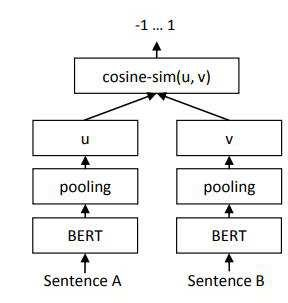


Here are some of the resources I used to create this notebook:

* James Briggs: Sentence Similarity with Sentence-Transformers in Python https://www.youtube.com/watch?v=Ey81KfQ3PQU&ab_channel=JamesBriggs
* James Briggs: Fine-tune Sentence Transformers the OG Way (with NLI Softmax loss) https://www.youtube.com/watch?v=aSx0jg9ZILo&t=1923s&ab_channel=JamesBriggs

Source Paper:
Reimers, Nils, and Iryna Gurevych. “Sentence-BERT: Sentence Embeddings Using Siamese BERT-Networks.” arXiv, August 27, 2019. http://arxiv.org/abs/1908.10084.


Beter method:
https://github.com/jamescalam/train-sentence-transformers/blob/94327317720a4a8cb70851969831e1885fe07f79/training/supervised/mnr/mnr-nli-negatives.ipynb#L43
https://github.com/jamescalam/train-sentence-transformers/blob/main/training/supervised/mnr/mnr-nli.ipynb

In [ ]:
import os
import datasets
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from transformers.optimization import get_linear_schedule_with_warmup, AdamW

# Dataset Preparation

We are using the Stanford Natural Language Inference (SNLI) dataset, which has the following labels:

SNLI is a widely used benchmark in natural language processing (NLP) and machine learning research. It was created by the Stanford NLP Group to evaluate models on the task of natural language inference, which involves determining the logical relationship between pairs of sentences.

The SNLI dataset consists of over half a million labeled pairs of sentences, collected from image captions on the Flickr website. Each pair of sentences is labeled with one of three classes indicating the relationship between them: "entailment," "contradiction," or "neutral." These labels represent whether the meaning of the first sentence logically entails, contradicts, or is neutral with respect to the meaning of the second sentence.

    0: entailment, the premise entails the hypothesis e.g. the sentences have the same meaning
    1: neutral, the premise and hypothesis are neutral e.g. the sentences could be true but have no relation
    2: contradiction, the premise contradicts the hypothesis e.g. the sentences have opposite meaning

In [ ]:
snli = datasets.load_dataset('snli', split='train')
snli

In [ ]:
# huggingface datasets can be spliced like a dataframe by key, but also can be spliced by index like a list
# snli["premise"]
snli[0:3]

We also look at the MultiNL (MNLI) dataset.

MNLI is another creation from the Stanford NLP Group, designed to further advance research in natural language processing (NLP) and machine learning. MNLI stands for Multi-Genre Natural Language Inference, and it serves as an extension and enhancement of the Stanford Natural Language Inference (SNLI) dataset.

In [ ]:
mnli = datasets.load_dataset('glue', 'mnli', split='train')
mnli = mnli.remove_columns(['idx'])
mnli

In [ ]:
# datsets need to be concatenated before they can be used. But need preprecessing first as they don't have the same columns
dataset = datasets.concatenate_datasets([snli, mnli]) # len = 942_854 samples

## Tokenize and encode sentences

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Preprocess labels: There are -1 labels in the dataset, which need to be removed
dataset = dataset.filter(
    lambda x: x['label'] != 0
)

In [ ]:
# Preprocess text: Tokenize and truncate
all_cols = ["label"]

i = 0
for sample in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[sample], max_length=128, padding='max_length', truncation=True, 
            ),
        batched=True # batched=True is required for map to work on a dataset
    )

    # renames 'input_ids' and 'attention_mask' to 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask'
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, f'{sample}_{col}'
        )
        all_cols.append(f'{sample}_{col}')
    if i == 99:
        break
print(all_cols) # ['label', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask']

In [ ]:
dataset.set_format(type='torch', columns=all_cols)

In [ ]:
batch_size = 16
dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Build Model Setup

In [ ]:
def mean_pool(token_embeddings, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float() # find padding tokens
    pool = torch.sum(token_embeddings * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9) # exclude padding tokens average based on axis 1
    return pool

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
cos_sim = nn.CosineSimilarity()
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 1

# setup warmup for first 10% of training steps
total_steps = int(len(dataset) / batch_size * epochs)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
    )

## Train Model

In [ ]:
# 1 epoch should be enough, increase if wanted

scale = 20.0 # scale logits to prevent loss explosion

for epoch in range(epochs):
    model.train()
    # initialize the dataloader loop with tqdm
    loop = tqdm(dataloader_train, leave=True)
    for batch in loop:
        # zero all gradients on each new step
        optimizer.zero_grad()
        # unpack batch from dataloader and send to device
        inputs_ids_a = batch['premise_input_ids'].to(device) # should be named "anchor"
        attention_mask_a = batch['premise_attention_mask'].to(device) 
        inputs_ids_b = batch['hypothesis_input_ids'].to(device) # should be named "positive"
        attention_mask_b = batch['hypothesis_attention_mask'].to(device)
        labels = batch['label'].to(device)
        # extract token embeddings from BERT
        anchor_embeds = model(inputs_ids_a, attention_mask=attention_mask_a)[0] # (batch_size, seq_len, 768) # [0] is the last_hidden_state
        pos_embeds = model(inputs_ids_b, attention_mask=attention_mask_b)[0] # (batch_size, seq_len, 768) # [0] is the last_hidden_state
        # pool the embeddings into single vector
        anchor_embeds = mean_pool(anchor_embeds, attention_mask_a)
        pos_embeds = mean_pool(pos_embeds, attention_mask_b)
        # calculate cosine similarity between the pooled embeddings
        scores = torch.stack([
            cos_sim(
                anchor.reshape(1, anchor_embeds.shape[0]), pos_embeds
            ) for anchor in anchor_embeds]) 
        # get labels from batch setup
        labels = torch.tensor(range(len(scores)), dtype=torch.long).to(device)   
        # calculate loss and update weights
        loss = criterion(scores*scale, labels)
        # calculate gradients
        loss.backward()
        # clip gradients to help with training stability
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # update learning rate scheduler to be linearly decreasing
        scheduler.step()
        # update the tqdm loop with current loss
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

## Save the model

In [ ]:
model_path = './sbert_pytorch.pt'

if not os.path.exists(model_path):
    torch.save(model.state_dict(), model_path)

The common practice in PyTorch is indeed to use torch.save(model.state_dict(), model_path) to save the model's state dictionary. This approach only saves the learned parameters of the model, not the model architecture itself. While this is often sufficient for many use cases, if you want to save the entire model, including its architecture, you have a few options.

1. Save Entire Model:
You can save the entire model, including its architecture and parameters, using torch.save(model, model_path). This will save the entire model object. However, keep in mind that this approach might be less flexible when it comes to loading the model on a different system or with different code versions.

torch.save(model, model_path)


2. Save Model Architecture and State Dict Separately:
You can save the model architecture and state dictionary separately. This allows you to reconstruct the model by instantiating a new model with the saved architecture and then loading the state dictionary.

### Save model architecture
torch.save(model, model_architecture_path)

### Save model state dictionary
torch.save(model.state_dict(), model_state_dict_path)
Later, to load the model:

### Load model architecture
loaded_model = torch.load(model_architecture_path)

### Instantiate a new model with the same architecture
new_model = YourModelClass(*args, **kwargs)
new_model.load_state_dict(torch.load(model_state_dict_path))
This way, you separate the model's architecture from its learned parameters, providing more flexibility.